<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: ???? </center></h4>
<h4><center> Filename: assignment_1_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Student Name, Student ID </center></h4>
<h4><center> Group Member 2: Student Name, Student ID </center></h4>
<h4><center> Group Member 3: Student Name, Student ID </center></h4>
<h4><center> Group Member 4: Student Name, Student ID </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



**To load data on Google Colab**:
1. Upload the data onto your Google Drive
2. Run the first cell to log in your Google account and mount on your Google Drive
3. Change *path_csv* and *path* accordingly

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [ ]:
# Google Colab import data: Much Faster to unzip files

!unzip "/content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip" -d "/content"

In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy
config.update("jax_platform_name", 'cpu') # use cpu if needed

import jax
import jax.numpy as jnp
import numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [2]:
print(jax.devices())

[CpuDevice(id=0)]


In [3]:
#load attributes csv file
path_csv  = "D:\\Academics\\DSA\\4212\\datasets" # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [4]:
#let us list all the files in the image directory
path = "D:\\Academics\\DSA\\4212\\datasets\\img_celeba_small" # Local Path (Change Here)
# path = "/content/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


## Common Utility Functions

In [5]:
# Image Loader

# #let us load the first 500 images
# n_img = 500
# img_array = onp.zeros((n_img, 100,100))
# for k in range(n_img):
#     im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
#     im = resize(im, (100,100) )
#     im = onp.mean(im, axis=2) # average the last channel
#     img_array[k,:,:] = im
    
def image_loader(indices, res, grey=False, verbose = 0):
    """
    Load Images

    args:
    indices: indices of the image to be loaded
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((indices.size, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
            if verbose == 1 & i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((indices.size, res[0], res[1], 3))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            if verbose == 1 & i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
        
    return img_array

def image_loader_fname(fnames, res, grey=False):
    """
    Load Images by File Names

    args:
    fnames: file names of the image to be loaded (a list)
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((len(fnames), res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((len(fnames), res[0], res[1], 3))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
            
    return img_array

In [6]:
# Predict P(Y=1|X, Beta)
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1. / (1. + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [ ]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

In [ ]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    print(f'Test Accuracy is {test_acc:.2f}')
    print(f'Test AUC is {test_auc:.2f}')
    
    return test_acc, test_auc

## Utility Functions for Basic Logistic Regression

In [7]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [8]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [11]:
### Ridge
@jax.jit
def loss_ridge(beta, X, Y, lambda_ridge=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_ridge: ridge parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = np.sum(loss_batch(beta, X, Y))
    loss_batch_ridge = loss_original + lambda_ridge*np.sum(beta**2)

    return loss_batch_ridge/len(Y)

# compute derivates
loss_ridge_grad = jax.jit(jax.grad(loss_ridge, argnums=0))
loss_ridge_values_and_grad = jax.jit(jax.value_and_grad(loss_ridge, argnums=0))

CpuDevice(id=0)

In [ ]:
@jax.jit
def loss_lasso(beta, X, Y, lambda_lasso=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_lasso: lasso parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = np.sum(loss_batch(beta, X, Y))
    loss_batch_lasso = loss_original + lambda_lasso*np.sum(np.abs(beta))

    return loss_batch_lasso/len(Y)

# compute derivates
loss_lasso_grad = jax.jit(jax.grad(loss_lasso, argnums=0))
loss_lasso_values_and_grad = jax.jit(jax.value_and_grad(loss_lasso, argnums=0))

## Utility Functions for Training Model and Backcalling

In [12]:
def train_SGD(train_img, train_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
    
    return loss_history, loss_history_end_epoch, test_acc_history, beta

In [13]:
def train_SGD_step_decay(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with step decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        
        if (epoch + 1) % n_steps == 0:
            learning_rate = learning_rate * lr_decay
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
    return loss_history, loss_history_end_epoch, test_acc_history, beta

In [14]:
def train_SGD_heuristic(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, valid_size=0.2, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with heuristic learning rate decay using SGD with heuristic learning rate decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     valid_size: Proportion of training images to be used as validation data
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     valid_acc_history: Valid accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    valid_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr
    
    valid_img_arr = train_img[int(-valid_size*N):]
    valid_label = train_label[int(-valid_size*N):]

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        
        valid_acc_new = get_accuracy(pred_proba_batch(beta, valid_img_arr), valid_label)
        valid_acc_history.append(valid_acc_new)
        
        if epoch == 0:
            valid_acc = valid_acc_new
        elif valid_acc_new < valid_acc:
            learning_rate = learning_rate * lr_decay
        valid_acc = valid_acc_new
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Validation Accuracy: {valid_acc:.3f}")
    return loss_history, loss_history_end_epoch, valid_acc_history, beta

In [20]:
## with fixed decay_constant
def train_SGD_scheduled_decay(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, decay_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with scheduled decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     decay_constant: choise of decay_constant, defult 0.5
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start

        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        
        learning_rate = learning_rate /(1 + decay_constant*epoch) # Schedule decay

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")

    return loss_history, loss_history_end_epoch, test_acc_history, beta

In [25]:
## with fixed mom_constant
def train_SGD_mom(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD plus momentum
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     mom_constant: choise of momentum constant, default 0.5

    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom


            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")

    return loss_history, loss_history_end_epoch, test_acc_history, beta

## Utility Functions for Plotting Graph

In [15]:
def plot_loss(loss_history):
    plt.plot(loss_history, "-^")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.grid(True)

## Import Data
### Notice: Images are only loaded as file names at this stage, to read as numerical arrays, use image_loader/image_loader_fname

In [16]:
# Proportion of Males in first 15000? first 200?
train_img = all_img[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1)

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_small_img = all_img[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1)

### Delete the arrays to clear up memeory and prevent RAM OOM

In [17]:
import gc
def clear_image_cache(var_list):
    for var in var_list:
        if var in globals().keys():
            del globals()[var]
    gc.collect()
# del test_img_arr
# del train_img_arr

### Convert images into numerical arrays

In [18]:
img_list = ['test_img_arr', 'train_img_arr']
clear_image_cache(img_list)

pixels = 178
res = [pixels, pixels]
grey = False

train_img_arr = image_loader_fname(train_img, res, grey)
test_img_arr = image_loader_fname(test_img, res, grey)

Number of images imported: 1000, Time elapsed: 9.65
Number of images imported: 2000, Time elapsed: 18.35
Number of images imported: 3000, Time elapsed: 26.79
Number of images imported: 4000, Time elapsed: 34.78
Number of images imported: 5000, Time elapsed: 42.90
Number of images imported: 6000, Time elapsed: 51.66
Number of images imported: 7000, Time elapsed: 60.36
Number of images imported: 8000, Time elapsed: 68.27
Number of images imported: 9000, Time elapsed: 76.83
Number of images imported: 10000, Time elapsed: 84.80
Number of images imported: 11000, Time elapsed: 93.06
Number of images imported: 12000, Time elapsed: 101.02
Number of images imported: 13000, Time elapsed: 109.12
Number of images imported: 14000, Time elapsed: 117.36
Number of images imported: 15000, Time elapsed: 125.48
Number of images imported: 1000, Time elapsed: 7.75
Number of images imported: 2000, Time elapsed: 15.64
Number of images imported: 3000, Time elapsed: 23.60
Number of images imported: 4000, Time 

In [21]:
train_img_arr.shape

(15000, 95052)

In [22]:
test_img_arr.shape

(5000, 95052)

## Basic SGD

In [23]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / pixels
beta_init = np.random.normal(0,beta_standard_dev,3*pixels*pixels)

In [24]:
loss_SGD, loss_epoch_SGD, test_acc_SGD, beta_SGD = train_SGD(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 100, verbose = 1)

Epoch 0: 5.33 seconds, Loss: 12.15, Test Accuracy: 0.665
Epoch 1: 4.10 seconds, Loss: 9.20, Test Accuracy: 0.685
Epoch 2: 4.29 seconds, Loss: 7.95, Test Accuracy: 0.707
Epoch 3: 4.28 seconds, Loss: 7.07, Test Accuracy: 0.720
Epoch 4: 4.39 seconds, Loss: 6.49, Test Accuracy: 0.720
Epoch 5: 4.42 seconds, Loss: 6.10, Test Accuracy: 0.742
Epoch 6: 4.17 seconds, Loss: 5.74, Test Accuracy: 0.749
Epoch 7: 4.25 seconds, Loss: 5.34, Test Accuracy: 0.757
Epoch 8: 3.97 seconds, Loss: 5.15, Test Accuracy: 0.738
Epoch 9: 4.39 seconds, Loss: 4.81, Test Accuracy: 0.764
Epoch 10: 4.20 seconds, Loss: 4.61, Test Accuracy: 0.777
Epoch 11: 4.04 seconds, Loss: 4.39, Test Accuracy: 0.778
Epoch 12: 3.94 seconds, Loss: 4.24, Test Accuracy: 0.786
Epoch 13: 3.94 seconds, Loss: 4.17, Test Accuracy: 0.790
Epoch 14: 3.92 seconds, Loss: 3.99, Test Accuracy: 0.786
Epoch 15: 3.90 seconds, Loss: 3.89, Test Accuracy: 0.793
Epoch 16: 3.87 seconds, Loss: 3.73, Test Accuracy: 0.800
Epoch 17: 3.87 seconds, Loss: 3.64, Test

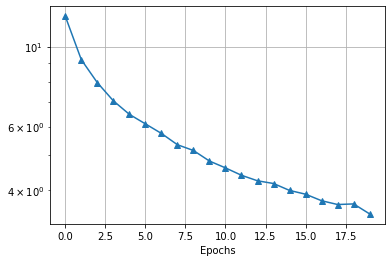

In [26]:
plot_loss(loss_epoch_SGD)

In [27]:
acc_test, auc_test = test_acc_auc(beta_SGD, test_label, test_img_arr)

Test Accuracy is 0.80
Test AUC is 0.88


## Annealing

### Step Decay

In [28]:
loss_step, loss_epoch_step, test_acc_step, beta_step = train_SGD_step_decay(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size=100, verbose = 1)

Epoch 0: 4.20 seconds, Loss: 12.04, Test Accuracy: 0.658
Epoch 1: 4.26 seconds, Loss: 9.18, Test Accuracy: 0.681
Epoch 2: 4.54 seconds, Loss: 8.01, Test Accuracy: 0.700
Epoch 3: 4.08 seconds, Loss: 7.17, Test Accuracy: 0.718
Epoch 4: 4.03 seconds, Loss: 6.55, Test Accuracy: 0.724
Epoch 5: 4.08 seconds, Loss: 5.94, Test Accuracy: 0.733
Epoch 6: 4.01 seconds, Loss: 5.71, Test Accuracy: 0.739
Epoch 7: 4.06 seconds, Loss: 5.52, Test Accuracy: 0.747
Epoch 8: 3.99 seconds, Loss: 5.38, Test Accuracy: 0.752
Epoch 9: 4.12 seconds, Loss: 5.23, Test Accuracy: 0.752
Epoch 10: 4.13 seconds, Loss: 5.07, Test Accuracy: 0.753
Epoch 11: 4.12 seconds, Loss: 4.97, Test Accuracy: 0.758
Epoch 12: 4.17 seconds, Loss: 4.93, Test Accuracy: 0.757
Epoch 13: 4.12 seconds, Loss: 4.88, Test Accuracy: 0.761
Epoch 14: 4.03 seconds, Loss: 4.81, Test Accuracy: 0.762
Epoch 15: 4.02 seconds, Loss: 4.73, Test Accuracy: 0.763
Epoch 16: 4.22 seconds, Loss: 4.70, Test Accuracy: 0.764
Epoch 17: 4.36 seconds, Loss: 4.70, Test

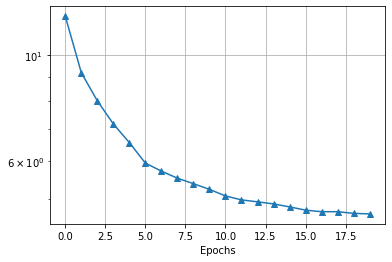

In [29]:
plot_loss(loss_epoch_step)

In [30]:
acc_test, auc_test = test_acc_auc(beta_step, test_label, test_img_arr)

Test Accuracy is 0.77
Test AUC is 0.83


### Heuristic

In [31]:
loss_heuristic, loss_epoch_heuristic, valid_acc_heuristic, beta_heuristic = train_SGD_heuristic(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, verbose = 1)

Epoch 0: 4.02 seconds, Loss: 12.20, Validation Accuracy: 0.646
Epoch 1: 3.94 seconds, Loss: 9.25, Validation Accuracy: 0.669
Epoch 2: 4.20 seconds, Loss: 7.94, Validation Accuracy: 0.678
Epoch 3: 4.22 seconds, Loss: 7.13, Validation Accuracy: 0.683
Epoch 4: 4.03 seconds, Loss: 6.50, Validation Accuracy: 0.710
Epoch 5: 4.02 seconds, Loss: 5.96, Validation Accuracy: 0.721
Epoch 6: 3.93 seconds, Loss: 5.61, Validation Accuracy: 0.730
Epoch 7: 3.97 seconds, Loss: 5.33, Validation Accuracy: 0.744
Epoch 8: 4.14 seconds, Loss: 5.03, Validation Accuracy: 0.752
Epoch 9: 4.03 seconds, Loss: 4.83, Validation Accuracy: 0.753
Epoch 10: 3.99 seconds, Loss: 4.56, Validation Accuracy: 0.740
Epoch 11: 3.98 seconds, Loss: 4.33, Validation Accuracy: 0.765
Epoch 12: 4.08 seconds, Loss: 4.25, Validation Accuracy: 0.763
Epoch 13: 3.96 seconds, Loss: 4.16, Validation Accuracy: 0.768
Epoch 14: 4.56 seconds, Loss: 4.11, Validation Accuracy: 0.770
Epoch 15: 5.30 seconds, Loss: 4.07, Validation Accuracy: 0.771
E

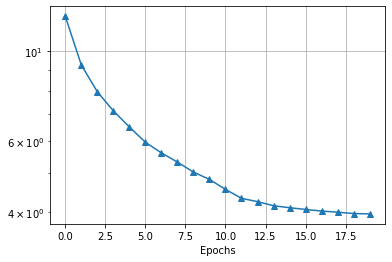

In [32]:
plot_loss(loss_epoch_heuristic)

In [33]:
acc_test, auc_test = test_acc_auc(beta_heuristic, test_label, test_img_arr)

Test Accuracy is 0.79
Test AUC is 0.85


### 1/t decay

In [37]:
loss_schedule, loss_epoch_schedule, test_acc_schedule, beta_schedule = train_SGD_scheduled_decay(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 100, verbose = 1)

Epoch 0: 4.36 seconds, Loss: 12.15, Test Accuracy: 0.666
Epoch 1: 4.11 seconds, Loss: 9.25, Test Accuracy: 0.688
Epoch 2: 4.15 seconds, Loss: 7.91, Test Accuracy: 0.695
Epoch 3: 4.13 seconds, Loss: 7.39, Test Accuracy: 0.700
Epoch 4: 4.60 seconds, Loss: 7.13, Test Accuracy: 0.704
Epoch 5: 4.10 seconds, Loss: 7.06, Test Accuracy: 0.704
Epoch 6: 4.48 seconds, Loss: 7.04, Test Accuracy: 0.706
Epoch 7: 3.98 seconds, Loss: 7.02, Test Accuracy: 0.707
Epoch 8: 3.92 seconds, Loss: 7.02, Test Accuracy: 0.707
Epoch 9: 3.93 seconds, Loss: 7.01, Test Accuracy: 0.707
Epoch 10: 3.92 seconds, Loss: 7.02, Test Accuracy: 0.707
Epoch 11: 4.40 seconds, Loss: 7.03, Test Accuracy: 0.707
Epoch 12: 4.19 seconds, Loss: 7.02, Test Accuracy: 0.707
Epoch 13: 4.27 seconds, Loss: 7.02, Test Accuracy: 0.707
Epoch 14: 3.99 seconds, Loss: 7.01, Test Accuracy: 0.707
Epoch 15: 4.30 seconds, Loss: 7.02, Test Accuracy: 0.707
Epoch 16: 4.25 seconds, Loss: 7.01, Test Accuracy: 0.707
Epoch 17: 3.93 seconds, Loss: 7.01, Test

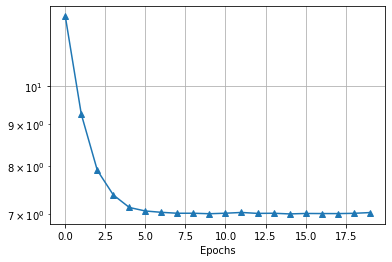

In [38]:
plot_loss(loss_epoch_schedule)

In [39]:
acc_test, auc_test = test_acc_auc(beta_schedule, test_label, test_img_arr)

Test Accuracy is 0.71
Test AUC is 0.76


## Momentum a.k.a Heavy Ball Method

In [40]:
loss_mom, loss_epoch_mom, test_acc_mom, beta_mom = train_SGD_mom(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 20, mb_size = 100, verbose = 1)

Epoch 0: 4.10 seconds, Loss: 11.02, Test Accuracy: 0.658
Epoch 1: 4.00 seconds, Loss: 7.72, Test Accuracy: 0.718
Epoch 2: 4.01 seconds, Loss: 6.39, Test Accuracy: 0.743
Epoch 3: 3.93 seconds, Loss: 5.60, Test Accuracy: 0.756
Epoch 4: 3.94 seconds, Loss: 5.01, Test Accuracy: 0.754
Epoch 5: 3.92 seconds, Loss: 4.59, Test Accuracy: 0.776
Epoch 6: 3.92 seconds, Loss: 4.28, Test Accuracy: 0.788
Epoch 7: 3.98 seconds, Loss: 3.96, Test Accuracy: 0.792
Epoch 8: 3.95 seconds, Loss: 3.78, Test Accuracy: 0.797
Epoch 9: 3.90 seconds, Loss: 3.65, Test Accuracy: 0.807
Epoch 10: 3.94 seconds, Loss: 3.50, Test Accuracy: 0.811
Epoch 11: 3.97 seconds, Loss: 3.36, Test Accuracy: 0.807
Epoch 12: 4.09 seconds, Loss: 3.18, Test Accuracy: 0.806
Epoch 13: 4.07 seconds, Loss: 3.04, Test Accuracy: 0.820
Epoch 14: 4.06 seconds, Loss: 2.90, Test Accuracy: 0.825
Epoch 15: 3.95 seconds, Loss: 2.80, Test Accuracy: 0.830
Epoch 16: 4.21 seconds, Loss: 2.75, Test Accuracy: 0.827
Epoch 17: 4.32 seconds, Loss: 2.69, Test

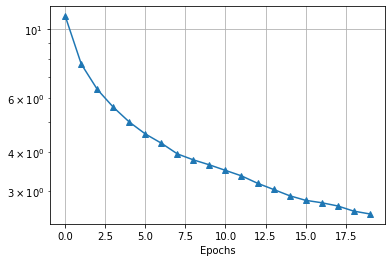

In [41]:
plot_loss(loss_epoch_mom)

In [42]:
acc_test, auc_test = test_acc_auc(beta_mom, test_label, test_img_arr)

Test Accuracy is 0.84
Test AUC is 0.91
